In [14]:
import tensorflow as tf
import numpy as np

The camera resoultion used by the jetson nano is 3040 x 4032, 95:126

The thermal camera resoultion is 512 x 640 4:5

In U-Net, the input size is 256 x 256 and so is the output. It consists of a series of downampling tensors, with the ith tensor as follows:

Convolutional layer with 64 * 2^i filters, 4x4 kernel size, same padding, strides of 1, and a leaky relu activation function
Maxpool layer with 2x2 pool size and 2x2 strides

It down samples until the size of the output is a 1x1x512 tensor

When upsampling, each tensor will be of the following form:
The input is a conactenation with the feature map on the downsampling layer with the same output size as well as the output from the previous tensor in the upsampling chain.
The concatenated input goes through a 4x4 transposed convolution with stride 2 and same padding, then a Batch normalization layer, followed by a ReLu layer

Because of the concatenations with feature maps of the same resolution, and since the input and output images for my data have different aspect ratios, there must be some work done to the image sizes before using the U-Net architecture

multiples of 512 x 640:
1024 x 1280
1536 x 1920
2048 x 2560
2560 x 3200
3072 x 3840

Ideas:
- pad 16 on both sides veritcally on the input image, then crop 96 off both sides horizontally
    - results in (3072 x 3840)
    - Plan: 
        - conv2d same padding, maxpool: strides = 3,3 pool size = 3,3 --> 1024 x 1280
        - Conv2D same padding, maxpool: strides = 2,2 pool size = 2,2 --> 512 x 640
        - U-Net from here (also might want to use the above tensor for the discriminator input)
- 8 conv2D maxpool with change in feature map size each tensor as (-60, -104)
    - results in (2560 x 3200)
   


By the way, the input tensor channels I will try are:
- 1 of them: just the IR image subtraction
- 4 of them: image subtraction union Optical
- 6 of them: optical union NoIR
- 7 of them: optical union NoIR union image subtration

In [15]:
input_tensor = tf.keras.layers.Input(shape=(3072, 3840, 7))
x = tf.keras.layers.Conv2D(filters=1024, kernel_size=(3,3), padding='same', strides=1)(input_tensor)
x = tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=(3,3))(x) # down sample to 1024 by 1280
x = tf.keras.layers.LeakyReLU()(x)
x = tf.keras.layers.Conv2D(filters=512, kernel_size=(3,3), padding='same', strides=1)(x)
x = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2))(x) # down sample to 512 by 640
x = tf.keras.layers.LeakyReLU()(x) # This will be the last downsample layer necessary for concatenation on the upsample
x.shape

2023-10-29 15:13:49.886686: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-10-29 15:13:49.886888: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-29 15:13:49.887053: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 4080 computeCapability: 8.9
coreClock: 2.52GHz coreCount: 76 deviceMemorySize: 15.68GiB deviceMemoryBandwidth: 667.63GiB/s
2023-10-29 15:13:49.887074: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-10-29 15:13:49.887093: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2023-10-29 15:13:49.887102: I tensorflow/stream_executor/platform

TensorShape([None, 512, 640, 512])

In [16]:
def down_sample(filter_count, kernel_size):
  out_tensor = tf.keras.Sequential()
  out_tensor.add(tf.keras.layers.Conv2D(filters=filter_count, kernel_size=(4,4), padding='same', strides=(2,2)))
  out_tensor.add(tf.keras.layers.LeakyReLU())
  return out_tensor

In [17]:
down_sample(512, 4)

In [18]:
def up_sample(filter_count, kernel_size):
  out_tensor = tf.keras.Sequential()
  out_tensor.add(tf.keras.layers.Conv2DTranspose(filters=filter_count, kernel_size=kernel_size, padding='same', strides=(2,2)))
  out_tensor.add(tf.keras.layers.BatchNormalization())
  return out_tensor

In [19]:
down0 = x
down1 = down_sample(512, 4)(down0) # (512, 640) / 2 = (256, 320)
down2 = down_sample(512, 4)(down1) # (256, 320) / 2 = (128, 160)
down3 = down_sample(512, 4)(down2) # (128, 160) / 2 = (64, 80)
down4 = down_sample(512, 4)(down3) # (64, 80) / 2 = (32, 40)
down5 = down_sample(512, 4)(down4) # (32, 40) / 2 = (16, 20)
down6 = down_sample(1024, 4)(down5) # (16, 20) / 2 = (8, 10)
down7 = down_sample(2048, 4)(down6) # (8, 10) / 2 = (4, 5)
# now upsample

In [20]:
down7.shape

TensorShape([None, 4, 5, 2048])

In [21]:
up0 = up_sample(1024, 4)(down7)
conc0to1 = tf.keras.layers.Concatenate()([up0, down6]) # concatenating 1024's
up1 = up_sample(512, 4)(up0)
conc1to2 = tf.keras.layers.Concatenate()([up1, down5]) # concat the 512's
up2 = up_sample(512, 4)(conc1to2)
conc2to3 = tf.keras.layers.Concatenate()([up2, down4]) # and so on
up3 = up_sample(512,4)(conc2to3)
conc3to4 = tf.keras.layers.Concatenate()([up3, down3])
up4 = up_sample(512, 4)(conc3to4)
conc4to5 = tf.keras.layers.Concatenate()([up4, down2])
up5 = up_sample(512,4)(conc4to5)
conc5to6 = tf.keras.layers.Concatenate()([up5, down1])
up6 = up_sample(512,4)(conc5to6)
conc6to7 = tf.keras.layers.Concatenate()([up6, x])
output_tensor = tf.keras.layers.Conv2D(filters=64, padding='same', kernel_size=(4,4), strides=1)(conc6to7)
output_tensor = tf.keras.layers.Conv2D(filters=3, padding='same', kernel_size=(4,4), strides=1, name='predicted')(output_tensor)

In [22]:
model = tf.keras.models.Model(inputs=input_tensor, outputs=output_tensor)

In [23]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 3072, 3840,  0                                            
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 3072, 3840, 1 65536       input_4[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 1024, 1280, 1 0           conv2d_3[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 1024, 1280, 1 0           max_pooling2d[0][0]              
______________________________________________________________________________________________

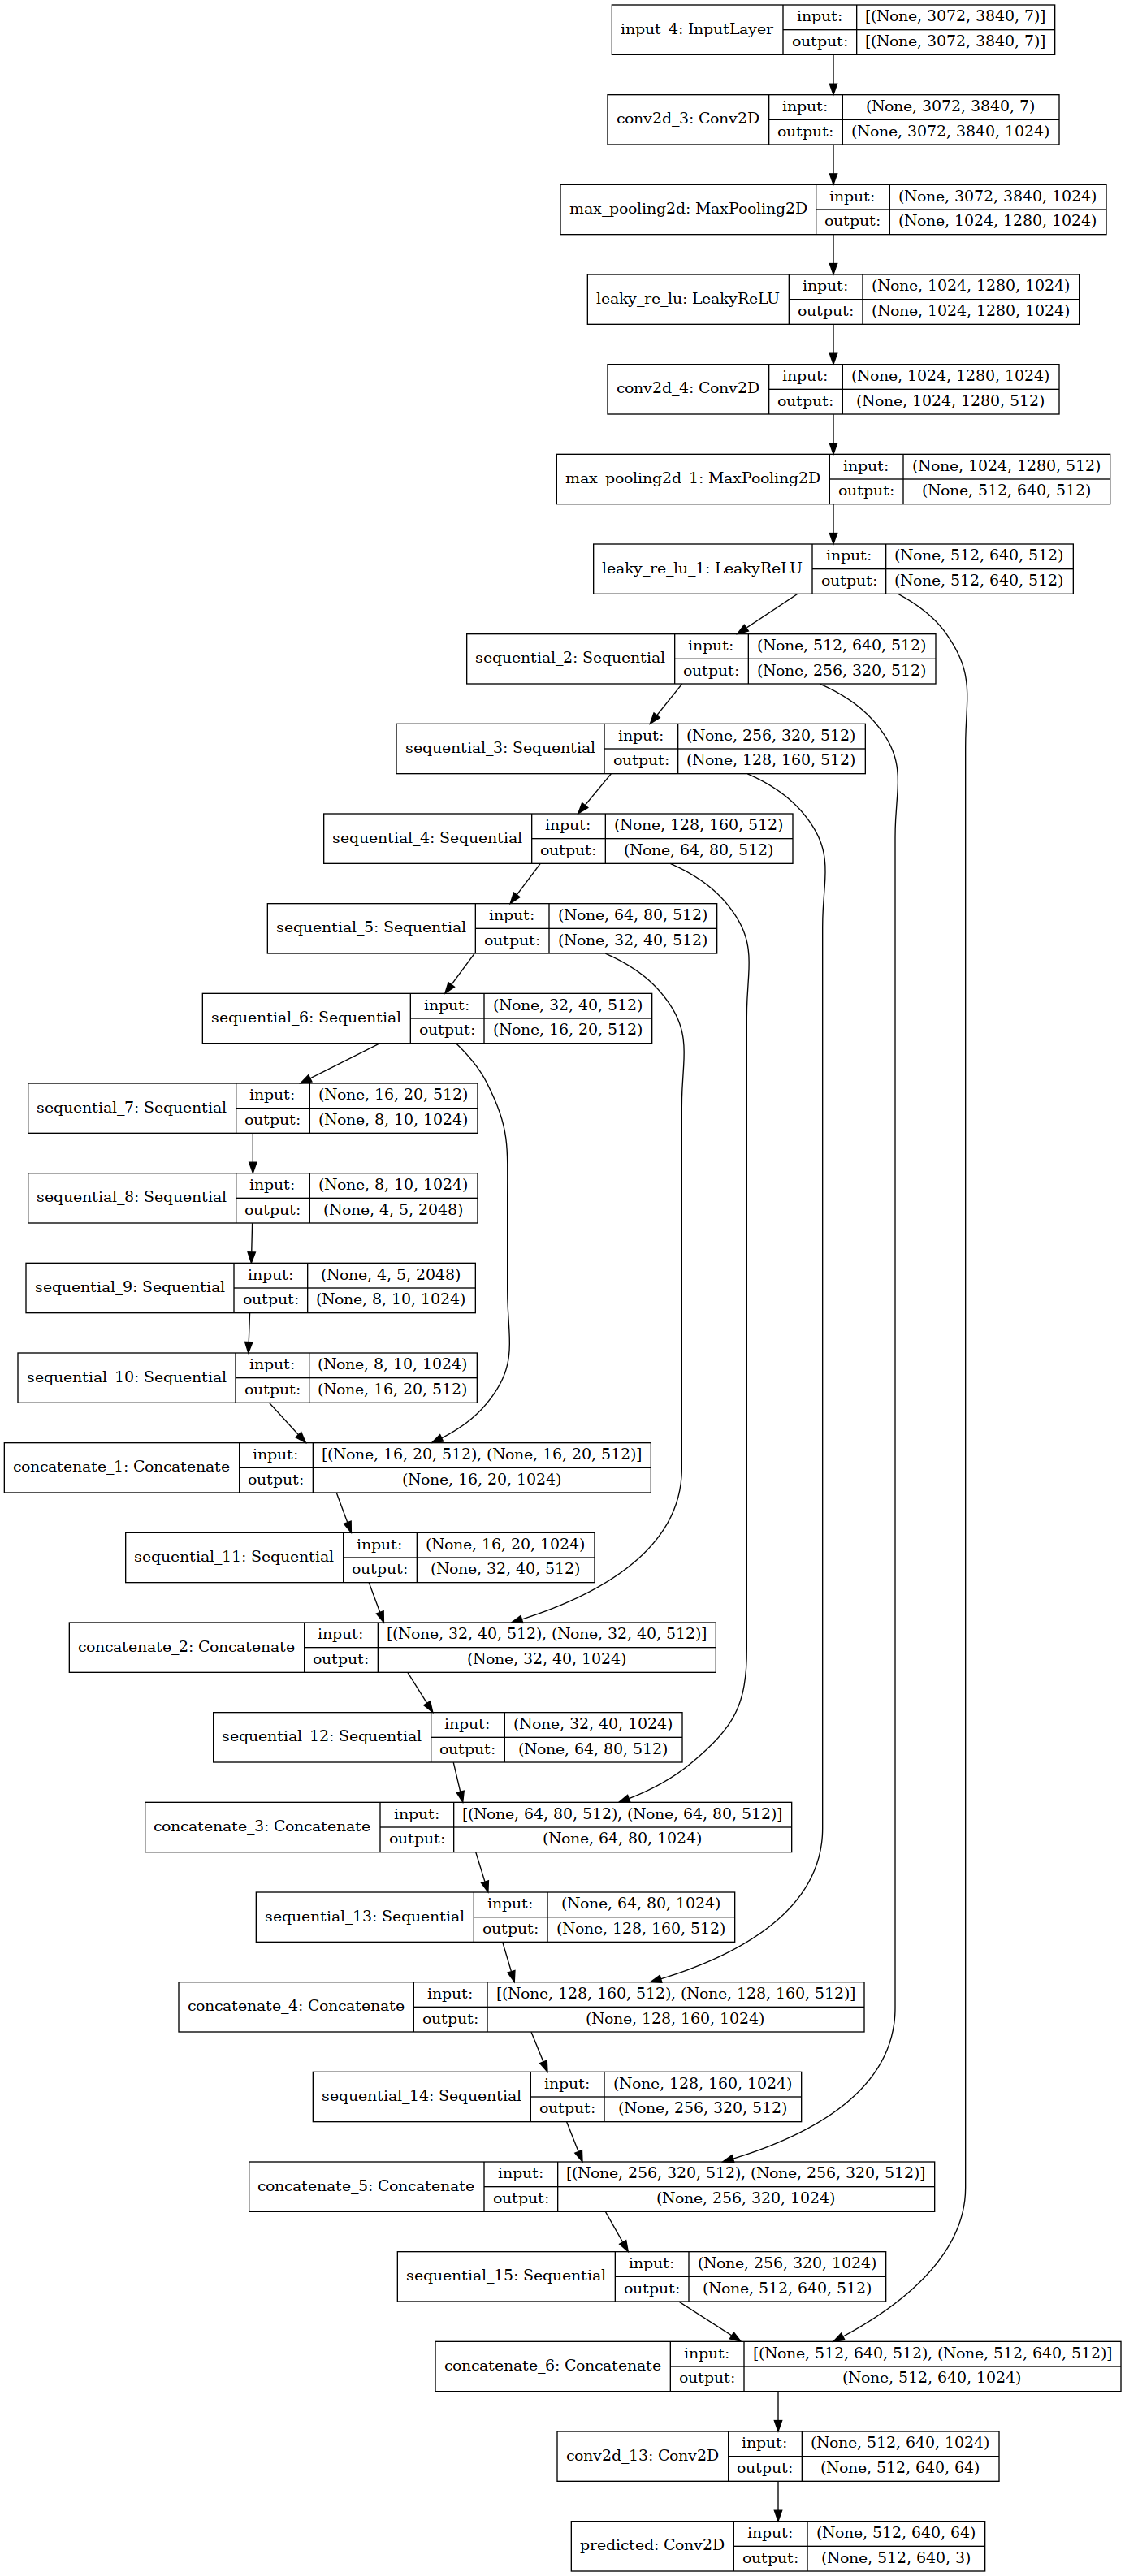

In [25]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [27]:
def preprocess(image):
    image = np.array(image, dtype='f')
    image = (image/127.5) - 1
    retval = tf.convert_to_tensor(image)
    
    retval = tf.expand_dims(retval, axis=0)
    
    return retval

In [30]:
# load and preprocess the train set here
x_train = {} # file name --> (filtered, unfiltered, subtraction)
y_train = {} # file name --> thermal

In [28]:
import random
num_epochs= 30
batch_size = 1
xentropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
mse = tf.keras.losses.MeanSquaredError()
l1 = lambda y_true, y_pred : tf.reduce_mean(tf.abs(y_true - y_pred))

In [29]:
gen_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discrim_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=.5)

In [ ]:
denom = 10**4
for epoch_i in range(num_epochs):
   # random.shuffle(x_train)
    epoch_gen_loss = 0.0
    epoch_discrim_loss = 0.0
    epoch_l1_loss = 0.0
    for i in range(int(len(x_train)/batch_size)):
        batch_gen_loss = 0.0
        batch_discrim_loss = 0.0
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            for j in range(batch_size):
                file_name = files_on_path[random.randrange(len(x_train))]
                gen_output = model(x_train[file_name], training=True)
                disc_fake = discrim([gen_output, x_train[file_name]], training=True)
                output_asif_real = tf.ones_like(disc_fake)
                this_l1 = l1(gen_output, y_train[file_name])
                epoch_l1_loss += this_l1
                batch_gen_loss += 100*this_l1 + xentropy(output_asif_real, disc_fake)
               # print("mse", mse(gen_output, y_train[rnd_j]))
                disc_fake = discrim([gen_output, x_train[file_name]], training=True)
                disc_real = discrim([y_train[file_name], x_train[file_name]], training=True)
                real_logits = tf.ones_like(disc_real)
                fake_logits = tf.zeros_like(disc_fake)
                batch_discrim_loss += xentropy(real_logits, disc_real) + xentropy(fake_logits, disc_fake)

            gen_grad = gen_tape.gradient(batch_gen_loss, model.trainable_variables)
            gen_optimizer.apply_gradients(grads_and_vars=zip(gen_grad, model.trainable_variables))

            discrim_grad = disc_tape.gradient(batch_discrim_loss, discrim.trainable_variables)
            discrim_optimizer.apply_gradients(grads_and_vars=zip(discrim_grad, discrim.trainable_variables))
            epoch_gen_loss += batch_gen_loss
            epoch_discrim_loss += batch_discrim_loss

    print('Epoch ', epoch_i, 'Generator Loss: ', epoch_gen_loss.numpy()/len(x_train), ' Discriminator Loss: ', epoch_discrim_loss.numpy()/len(x_train), 'L1: ', epoch_l1_loss.numpy()/len(x_train))
    model.save_weights('./epoch_'+str(epoch_i))